# Sample run for Fisher Market

In [1]:
using Pkg
Pkg.activate("../")

  Activating project at `~/workspace/ExchangeMarket.jl/scripts`


In [4]:
using Revise
using SparseArrays, LinearAlgebra
using JuMP, MosekTools
using Plots, LaTeXStrings, Printf, Random
import MathOptInterface as MOI

using ExchangeMarket

include("../tools.jl")
include("../plots.jl")

switch_to_pdf(;)


:pdf

## Test different $\rho$ in a CES Economy

Run CES economy by HessianBarrier method (primal-dual predictor-corrector mode)

! note this example is quite large, use smaller $n, m$ if needed

In [12]:
Random.seed!(1234)
n = 50
m = 1000

1000

In [14]:
ρfmt = @sprintf("%+.1f", ρ)
σfmt = @sprintf("%+.1f", f0.σ)

name = :HessianBarPD
method = HessianBar
kwargs = Dict(:tol => 1e-10, :maxiter => 20, :optimizer => EGConicAC, :linsys => :dr1, :option_step => :primal_dual)

results = []
for ρ in [-9, -0.9, 0.5, 0.9, 0.95, 0.99]

    f0 = FisherMarket(m, n; ρ=ρ, bool_unit=true, sparsity=0.95)
    linconstr = LinearConstr(1, n, ones(1, n), [sum(f0.w)])
    ρfmt = @sprintf("%+.2f", ρ)
    σfmt = @sprintf("%+.2f", f0.σ)

    (name, method, kwargs) = method_kwargs[1]
    f1 = copy(f0)
    p₀ = ones(n) ./ m
    x₀ = 0.1 * ones(m, n)
    f1.x .= x₀
    f1.p .= p₀
    alg = method(
        n, m, p₀;
        optimizer=EGConicAC,
        linconstr=linconstr,
        kwargs...
    )
    traj = opt!(
        alg, f1;
        keep_traj=true,
        tol=1e-8
    )
    push!(results, (ρ, (alg, traj, f1)))
end

------------------------------------------------------------------------------------------
                  ExchangeMarket.jl: A Julia Package for Exchange Market                  
                                  © Chuwen Zhang (2024)                                  
------------------------------------------------------------------------------------------
 subproblem solver alias       := EigenbergGaleAnalyticalCESResponse
 subproblem solver style       := analytic
 lin-system solver alias       := dr1
 option for gradient           := dual
 option for step               := primal_dual
 option for μ                  := normal
------------------------------------------------------------------------------------------
      k |  lg(μ) |           φ |    |∇φ| |    |Δp| |       t |      tₗ |       α |     kᵢ 
      0 |  -6.00 | -3.9449e+00 | 1.3e+02 | 1.3e-01 | 8.0e-03 | 8.0e-03 | 1.0e+00 | 2.0e+01 
      1 |  -7.00 | -5.9895e+00 | 1.3e-01 | 9.7e-03 | 1.6e-02 | 1.6e-02 | 9.3e-01 | 2.0e

### Validate results

In [16]:
for (ρ, (alg, traj, f1)) in results
    validate(f1, alg)
end

----------------------------------------------------------------------------------------------------
 :problem size
 :    number of agents: 1000
 :    number of goods: 50
 :    avg number of nonzero entries in c: 0.9509
 :equilibrium information
 :method: HessianBar
----------------------------------------------------------------------------------------------------
10×3 DataFrame
 Row │ utility      left_budget   left_budget_μ 
     │ Float64      Float64       Float64       
─────┼──────────────────────────────────────────
   1 │ 0.000429833  -1.0842e-19     8.36131e-12
   2 │ 0.000493846   2.1684e-19     8.36131e-12
   3 │ 0.000935283  -4.33681e-19    8.36131e-12
   4 │ 0.000505379  -1.0842e-19     8.36131e-12
   5 │ 0.000572937   0.0            8.36131e-12
   6 │ 0.00156737    2.1684e-19     8.36131e-12
   7 │ 0.000412554   2.1684e-19     8.36131e-12
   8 │ 0.000212688  -5.42101e-20    8.36131e-12
   9 │ 0.00145136    4.33681e-19    8.36131e-12
  10 │ 0.0002801     5.42101e-20    8.

### Plot trajectory 

for each $\rho$, we plot the dual local norm $\|\nabla \varphi\|_{\mathbf{p}}^*$ of the trajectory.

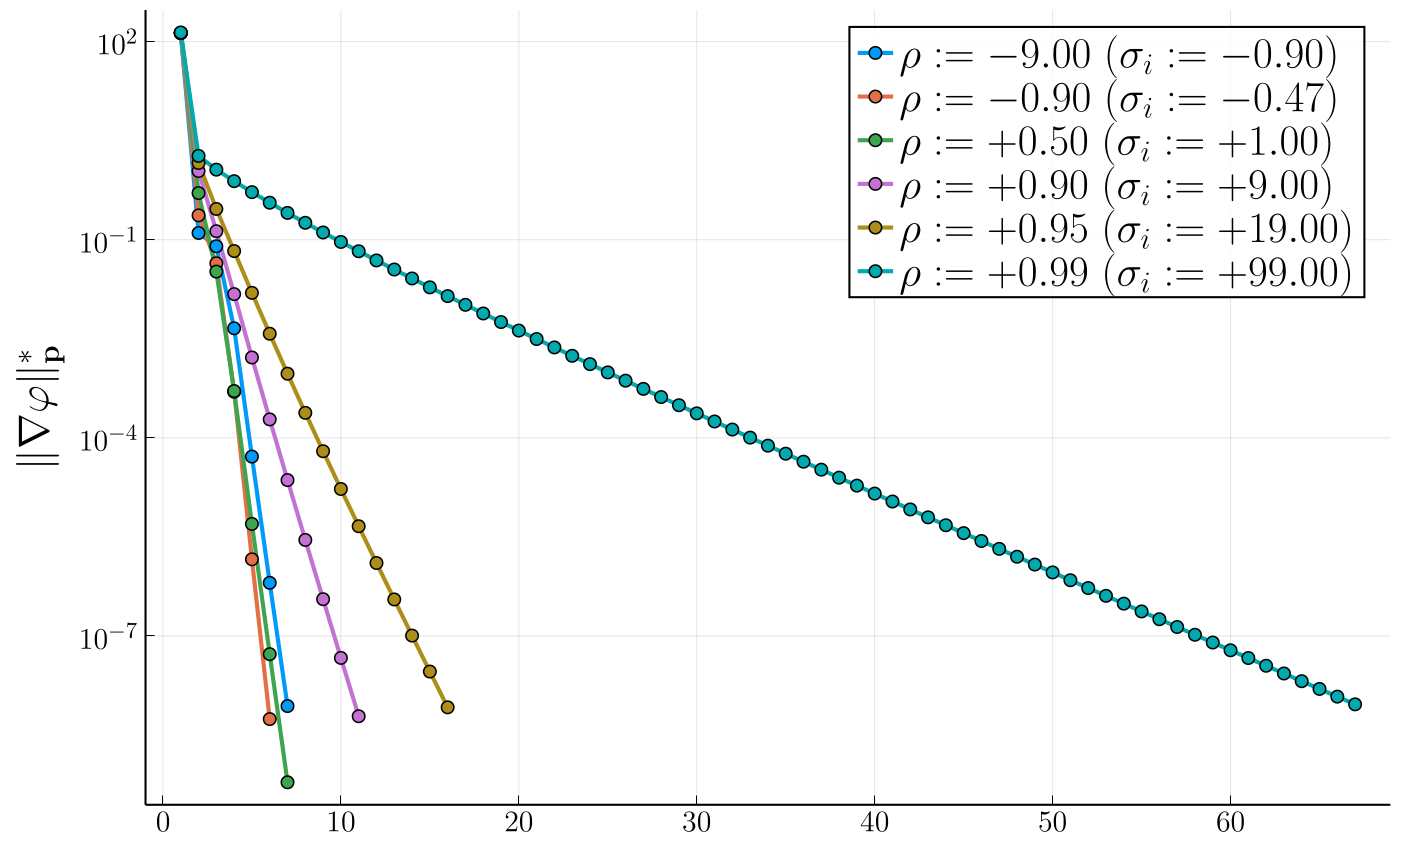

In [18]:
fig = generate_empty(; shape=:wide)
plot!(
    ylabel=L"$\|\nabla \varphi\|_{\mathbf{p}}^*$",
    legendbackgroundcolor=RGBA(1.0, 1.0, 1.0, 0.8),
    yticks=10.0 .^ (-10:3:3),
)

for (ρ, (alg, traj, f1)) in results
    ρfmt = @sprintf("%+.2f", ρ)
    σfmt = @sprintf("%+.2f", f1.σ)
    traj_pp₊ = map(pp -> pp.gₙ, traj)
    plot!(fig, traj_pp₊, label=L"$\rho := %$ρfmt~(\sigma_i := %$σfmt)$", linewidth=2, markershape=:circle)
end
fig